In [2]:
# Import Libraries
import os
import numpy as np
import cupy as cp
import librosa
import torch
import torchaudio
import concurrent.futures
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Constants
SAMPLE_RATE = 44100
DURATION = 1.0
N_MELS = 16
HOP_LENGTH = 512
N_FFT = 2048

In [4]:
# =================== FOR EACH TRACK ===================
# [GPU-Accelerated] Generate Mel Spectrogram with Normalization
def generate_mel_spect_gpu(audio_path, save_path=None):
    # Load audio
    y, _ = librosa.load(audio_path, sr=SAMPLE_RATE)

    # Normalize audio to [-1, 1]
    y = y / np.max(np.abs(y)) if np.max(np.abs(y)) > 0 else y  

    samples_per_segment = int(DURATION * SAMPLE_RATE)
    mel_spects = []

    # Compile spectrograms
    for start in range(0, len(y), samples_per_segment):
        # Get current segment
        end = start + samples_per_segment
        segment = y[start:end]
        if len(segment) < samples_per_segment:
            break

        # Define transformation
        tensor = torch.tensor(segment).to("cuda")
        apply_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_mels=N_MELS,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            center=False
        ).to("cuda")

        # Apply transformation
        mel_spect = apply_transform(tensor)
        mel_spect_db = torchaudio.transforms.AmplitudeToDB().to("cuda")(mel_spect)
        mel_spects.append(mel_spect_db.cpu().numpy())

    # Save to disk
    if save_path:
        np.save(save_path, np.array(mel_spects))

    return mel_spects


In [6]:
# =================== FOR EACH FOLDER ===================
# [Parallel] Generate all Mel Spectrograms
def process_dataset_parallel(dataset_path, save_dir):
    track_folders = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path) if d.startswith("Track")]
    os.makedirs(save_dir, exist_ok=True)

    # Helper Function
    def process_track(folder):
        mix_path = os.path.join(folder, "mix.flac")
        if os.path.exists(mix_path):
            # Request spectrogram
            track_name = os.path.basename(folder)
            save_path = os.path.join(save_dir, f"{track_name}_mel_spect.npy")  
            return generate_mel_spect_gpu(mix_path, save_path=save_path)
        return []

    # Parallel processing for requests
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        results = list(tqdm(executor.map(process_track, track_folders), desc="Processing Tracks"))
    
    return results

In [ ]:
# Collect Spectrograms (Train)
dataset_path = "slakh2100_flac_redux/train"
save_dir = "spectrograms_train"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

Processing Tracks: 100%|██████████| 1289/1289 [06:11<00:00,  3.47it/s]


In [ ]:
# Collect Spectrograms (Validation)
dataset_path = "slakh2100_flac_redux/validation"
save_dir = "spectrograms_validation"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

Processing Tracks: 100%|██████████| 270/270 [01:14<00:00,  3.60it/s]


In [52]:
# Collect Spectrograms (Test)
dataset_path = "slakh2100_flac_redux/test"
save_dir = "spectrograms_test"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

Processing Tracks: 100%|██████████| 151/151 [00:43<00:00,  3.45it/s]


In [29]:
# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced"
save_dir = "spectrograms_reduced"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

Processing Tracks: 270it [01:29,  3.00it/s]


In [39]:
# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced_test"
save_dir = "spectrograms_reduced_test"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

Processing Tracks: 151it [00:54,  2.79it/s]


In [5]:
# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced_train"
save_dir = "spectrograms_reduced_train"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

Processing Tracks: 1289it [07:24,  2.90it/s]


In [ ]:
# REDUCED BINS================================== 64
# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced"
save_dir = "spectrograms_sixtyfour"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced_test"
save_dir = "spectrograms_sixtyfour_test"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced_train"
save_dir = "spectrograms_sixtyfour_train"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

Processing Tracks: 270it [01:27,  3.09it/s]
Processing Tracks: 151it [00:48,  3.08it/s]
Processing Tracks: 1289it [06:41,  3.21it/s]


In [ ]:
# REDUCED BINS================================== 32
# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced"
save_dir = "spectrograms_thirtytwo"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced_test"
save_dir = "spectrograms_thirtytwo_test"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced_train"
save_dir = "spectrograms_thirtytwo_train"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

Processing Tracks: 270it [01:28,  3.04it/s]
Processing Tracks: 151it [00:51,  2.96it/s]
Processing Tracks: 1289it [06:39,  3.22it/s]


In [7]:
# REDUCED BINS================================== 16
# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced"
save_dir = "spectrograms_sixteen"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced_test"
save_dir = "spectrograms_sixteen_test"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

# Collect Spectrograms (Reduced)
dataset_path = "slakh2100_flac_redux/reduced_train"
save_dir = "spectrograms_sixteen_train"  
mel_spectrograms = process_dataset_parallel(dataset_path, save_dir)

Processing Tracks: 270it [01:22,  3.27it/s]
Processing Tracks: 151it [00:44,  3.36it/s]
Processing Tracks: 1289it [06:08,  3.50it/s]


(16, 83)


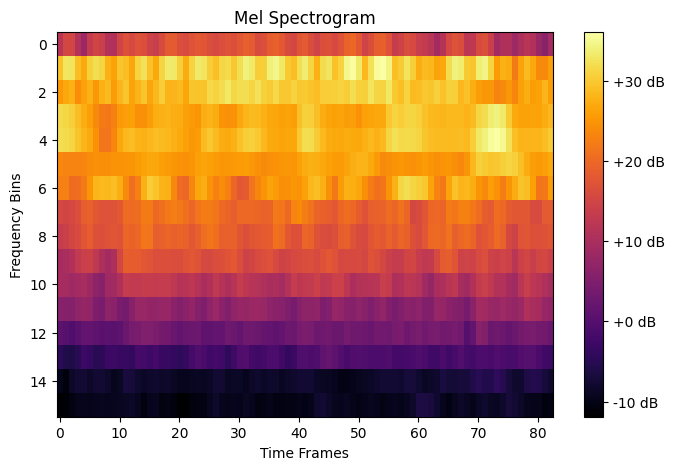

In [5]:
# Plotting Example
spectrogram = np.load('spectrograms_sixteen_test/Track01876_mel_spect.npy')
print(spectrogram[0].shape)
plt.figure(figsize=(8, 5))
plt.imshow(spectrogram[6], aspect='auto', cmap='inferno')  
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.show()

In [6]:
amplitude_spectrogram = 10**(spectrogram[6] / 20)
# Print amplitude values for the first and second columns
print("1st column Amplitude:\n", amplitude_spectrogram[:, 0])
print("1st column in dB:\n", spectrogram[6][:, 0])

1st column Amplitude:
 [ 3.8660302  29.73983    18.389109   38.38227    40.06209    14.774754
 13.597471    6.041364    4.678671    2.9946234   3.0150743   1.9735754
  1.0844488   0.59227264  0.3359872   0.25715885]
1st column in dB:
 [ 11.745305   29.46677    25.291214   31.682613   32.054672   23.390406
  22.669163   15.622701   13.402451    9.526844    9.58596     5.9050746
   0.7041815  -4.5495663  -9.473545  -11.79597  ]
